In [1]:
from bs4 import BeautifulSoup
import codecs
import re
import string
import Stemmer
import json

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [51]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Logge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Logge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Logge\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

# Обработка данных

In [52]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

1. Убрали стоп слова, цифры, пунктуацию.
2. Сделали стекинг

In [153]:
def process_text(text, stemmer):
    text_proc = text.lower()
    text_proc = re.sub(r'\d+', '', text_proc)
    
    text_list = re.findall(r'\w+', text_proc)
    
    stop_words_rus = set(stopwords.words("russian"))
    filtered_text = [word for word in text_list if word not in stop_words_rus]
    
    stems = [stemmer.stemWord(word) for word in filtered_text if len(word) > 1]
    
    return stems

In [154]:
def process_page(path, filename):
    with codecs.open(path + filename, 'r', 'utf-8') as f:
        url = f.readline().strip()
        page = BeautifulSoup(f, 'lxml')
        
        title = page.title.text
        text = page.body.text

        stemmer = Stemmer.Stemmer('russian')

        title_proc = process_text(title, stemmer)
        text_proc = process_text(text, stemmer)

    return {'doc_id': int(filename.split('.')[0]), 
            'title': " ".join(title_proc), 
            'text': " ".join(text_proc)}

In [155]:
import gzip
import json
import codecs
import sys
import os

from tqdm import tqdm
from multiprocessing.dummy import Pool, Queue

In [156]:
path = 'content/'

In [157]:
queue = Queue()   # очередь ссылок на книги

for filename in os.listdir(path):
    queue.put(filename)

queue.qsize()

28026

In [158]:
def process_page_wrapper(i):
    with gzip.open('data_processed/part_{:05d}.jsonl.gz'.format(i), mode='wb') as f_json:
        f_json = codecs.getwriter('utf8')(f_json)

        while not queue.empty():
            filename = queue.get()
            try:
                record = process_page(path, filename)
            except Exception as e:
                with lock:
                    print(filename, e, file=sys.stderr)
                record = dict()

            record_str = json.dumps(record, ensure_ascii=False)
            print(record_str, file=f_json)

            # счетчик должен атомарно обновиться
            with lock:
                pbar.update(1)

with Pool(processes=8) as pool, tqdm(total=queue.qsize()) as pbar:
    lock = pbar.get_lock()
    pool.map(process_page_wrapper, range(pool._processes))

100%|██████████████████████████████████████████████████████████████████████████| 28026/28026 [1:23:24<00:00,  5.60it/s]


In [159]:
import pandas as pd
import os

from itertools import chain         # рекомендуется использовать
from contextlib import ExitStack    # рекомендуется использовать

from typing import Generator, Dict, Any

In [160]:
def records_reader(dirname):
    filenames = os.listdir(dirname)

    with ExitStack() as stack:
        files = [stack.enter_context(gzip.open(f'data_processed/part_0000{i}.jsonl.gz',
                                               mode='rb')) for i in range(len(filenames))]
        files = list(map(lambda file: codecs.getreader('utf8')(file), files))
        
        for record in chain(*files):
            yield json.loads(record)

In [161]:
df = pd.DataFrame(records_reader('data_processed'))

In [185]:
df.doc_id = df.doc_id.astype(int)

Получили такой датасет.

In [186]:
df.head()

,doc_id,title,text
0,1,аншин центр репродукц генетик фертимед москв,аншин центр репродукц генетик фертимед москв с...
1,10008,беремен пар ног простуд простуд беремен bereme...,главн контакт простуд беремен беремен пар ног ...
2,10010,плед техник печворк бабочк готов подкладк друг...,войт регистрац напомн парол войт запомн начн н...
3,10034,наук финансов прав ярославск демидовск лиц,денежн обращен финанс кред основ финанс pravo ...
4,1004,пониз холестерин кров домашн услов быстр эффек...,норм кров расшифровк кров сдат кров калькулято...


In [179]:
df.loc[df.doc_id.isnull()] = [[13200, '', ''], [6693, '', ''], [7130, '', ''], [9332, '', '']]

In [187]:
df = df.sort_values(by = 'doc_id')
df.to_csv('data_processed.csv', index=False, sep=';')

In [188]:
df = None

# Построение признаков

In [10]:
from collections import Counter
import pandas as pd

Признаки: 

    1. Топ N - пересечений для заголовков.
    2. Топ N - пересечений для текстов.
    3. Взяли title_M - популярных слов из заголовков группы, и посмотрели, какие из них (и сколько встречаются) в тексте.
    4. Аналогично для текстов.
    5. Взяли популярные слова группы, популярные слова текста и нашли мощность пересечение.

In [218]:
def count_intersect_words(docs, N=20, title_M=10, text_M=25):
    X_temp = []
    
    title_counter = Counter()
    text_counter = Counter()
    
    #for k, (doc_id, title, count_text, target_id) in enumerate(docs):   #train
    
    for k, (doc_id, title, count_text) in enumerate(docs):  #test
        all_dist_title = []
        all_dist_text = []
        
        doc_title = title.strip().split()
        #doc_text = text.strip().split()
        
        title_counter.update(doc_title)
        text_counter.update({pair[0] : pair[1] for pair in count_text})
        
        words_title = set(doc_title)
        words_text = set([pair[0] for pair in count_text])
        
        for j in range(0, len(docs)):
            if k == j:
                continue
            #doc_id_j, title_j, count_text_j, target_j = docs[j] #train
            doc_id_j, title_j, count_text_j = docs[j]           #test
            
            words_title_j = set(title_j.strip().split())
            words_text_j = set([pair[0] for pair in count_text_j])
            
            all_dist_title.append(len(words_title.intersection(words_title_j)))
            all_dist_text.append(len(words_text.intersection(words_text_j)))
            
        X_temp.append(sorted(all_dist_title, reverse=True)[0:N] + sorted(all_dist_text, reverse=True)[0:N])
        
    title_most_common = title_counter.most_common(title_M)
    title_most_common_set = set([pair[0] for pair in title_most_common])
    
    text_most_common = text_counter.most_common(text_M)
    text_most_common_set = set([pair[0] for pair in text_most_common])
    
    #for k, (doc_id, title, count_text, target_id) in enumerate(docs):   #train
    for k, (doc_id, title, count_text) in enumerate(docs):  #test
        
        doc_counter = Counter(title.strip().split())
        doc_title_most_common_set = set([pair[0] for pair in doc_counter.most_common(title_M)])
    
        doc_count_title = list([doc_counter.get(word[0]) if doc_counter.get(word[0]) is not None else 0
                                for word in title_most_common])
        
        inter_title_1 = len(set(doc_counter).intersection(title_most_common_set))
        inter_title_2 = len(doc_title_most_common_set.intersection(title_most_common_set))
        
        doc_counter.clear()
        doc_counter.update({pair[0] : pair[1] for pair in count_text})
        doc_count_text = list([doc_counter.get(word[0]) if doc_counter.get(word[0]) is not None else 0
                               for word in text_most_common ])
        
        doc_text_most_common_set = set([pair[0] for pair in doc_counter.most_common(text_M)])
        
        inter_text_1 = len(set(doc_counter).intersection(text_most_common_set))
        inter_text_2 = len(doc_text_most_common_set.intersection(text_most_common_set))

        X_temp[k] += doc_count_title + doc_count_text + [inter_title_1, inter_title_2,
                                                         inter_text_1, inter_text_2]
        
    return X_temp

In [151]:
doc_to_title = {}
with open('data_processed.csv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split(';')
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            count_text = Counter(data[2].strip().split()).most_common(60)
            title = data[1]
        doc_to_title[doc_id] = [title, count_text]
print(len(doc_to_title))

28026


Загружили заголовки и самые популярные слова из текстов.

In [152]:
doc_to_title[1]

['аншин центр репродукц генетик фертимед москв',
 [('щитовидн', 56),
  ('желез', 56),
  ('определен', 34),
  ('гормон', 34),
  ('кров', 33),
  ('лабораторн', 31),
  ('анализ', 31),
  ('гормональн', 30),
  ('бесплод', 29),
  ('гиперфункц', 28),
  ('клиническ', 27),
  ('лг', 25),
  ('эндокрин', 24),
  ('ошибк', 24),
  ('нарушен', 24),
  ('гипофункц', 23),
  ('пациентк', 22),
  ('фсг', 21),
  ('исследован', 21),
  ('больн', 20),
  ('котор', 20),
  ('явля', 19),
  ('цикл', 19),
  ('содержан', 18),
  ('диагностик', 17),
  ('прл', 17),
  ('признак', 16),
  ('уровн', 16),
  ('результат', 16),
  ('дан', 16),
  ('норм', 16),
  ('эстрадиол', 15),
  ('случа', 15),
  ('ттг', 15),
  ('гиперандроген', 15),
  ('показан', 14),
  ('врач', 14),
  ('повышен', 14),
  ('уровен', 14),
  ('налич', 13),
  ('оценк', 13),
  ('лечен', 12),
  ('одн', 12),
  ('взят', 12),
  ('кс', 12),
  ('симптом', 12),
  ('поскольк', 11),
  ('отсутств', 11),
  ('функц', 11),
  ('утр', 11),
  ('друг', 11),
  ('гипотез', 10),
  ('

In [214]:
train_data = pd.read_csv('data/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id][0]
    count_text = doc_to_title[doc_id][1]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, count_text, target))

In [215]:
test_data = pd.read_csv('data/test_groups.csv')

In [216]:
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    
    title = doc_to_title[doc_id][0]
    count_text = doc_to_title[doc_id][1]
    
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title, count_text))

In [217]:
import numpy as np
y_train = []
X_train = []
groups_train = []

for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, count_text, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
    X_train += count_intersect_words(docs)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print(X_train.shape, y_train.shape, groups_train.shape)

(11690, 79) (11690,) (11690,)


In [220]:
np.savetxt('X_train.txt', X_train)

In [219]:
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title, count_text) in enumerate(docs):
        groups_test.append(new_group)
    X_test += count_intersect_words(docs)
        
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print(X_test.shape, groups_test.shape)

(16627, 79) (16627,)


In [221]:
np.savetxt('X_test.txt', X_test)

# Обучение моделей

In [281]:
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer as tf_idf
from sklearn.svm import OneClassSVM, SVC
from sklearn.neighbors import KNeighborsClassifier

In [164]:
group_kf = GroupKFold(n_splits=5)

In [222]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)

In [366]:
X_train

array([[ 5,  4,  4, ...,  5,  8,  4],
       [ 7,  7,  6, ...,  6, 14,  8],
       [ 3,  3,  3, ...,  4,  9,  7],
       ...,
       [ 0,  0,  0, ...,  0, 17, 13],
       [ 5,  0,  0, ...,  0, 10,  3],
       [ 1,  1,  1, ...,  0,  8,  6]])

### Логистическая регрессия

In [223]:
LogReg = LogisticRegression

In [269]:
params = {'C' : [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear', 'saga'], 'penalty':['l1', 'l2']}

In [270]:
grid_search_log = GridSearchCV(LogReg(), param_grid=params,
                               cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [271]:
grid_search_log.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   45.0s finished
C:\PyMol2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=True)

In [272]:
grid_search_log.best_score_, grid_search_log.best_params_

(0.6538086298381192, {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'})

Уже лучше

### RandomFosestClassifier

In [228]:
RandForest = RandomForestClassifier

In [229]:
params_rf = {'n_estimators' : [200],
             'min_samples_split':[2, 5, 8],
             'min_samples_leaf': [2, 5, 8],
             'max_features' : ["sqrt", "log2"],
             'max_samples' : [0.5, 0.8, 1]
             }

In [230]:
grid_search_rf = GridSearchCV(RandForest(), param_grid=params_rf,
                                     cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [231]:
grid_search_rf.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.2min finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                              

In [232]:
grid_search_rf.best_score_, grid_search_rf.best_params_

(0.6650968421036331,
 {'max_features': 'sqrt',
  'max_samples': 0.8,
  'min_samples_leaf': 8,
  'min_samples_split': 5,
  'n_estimators': 200})

In [233]:
forest = RandomForestClassifier(n_estimators=1000, min_samples_split=5, min_samples_leaf=8,
                                max_samples = 0.8, max_features = 'sqrt')

In [234]:
cross_val = cross_val_score(forest, X_train_scale, y_train, cv=group_kf, groups=groups_train, scoring='f1', n_jobs=-1)

In [235]:
cross_val.mean()

0.6624079226199789

### KNN

In [287]:
knn = KNeighborsClassifier

In [295]:
params_knn = {'n_neighbors':[2, 5, 8, 12], 'weights' :['uniform', 'distance']}

In [296]:
grid_search_knn = GridSearchCV(knn(), param_grid=params_knn,
                               cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [297]:
grid_search_knn.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   45.9s finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [2, 5, 8, 12],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=True)

In [298]:
grid_search_knn.best_score_, grid_search_knn.best_params_

(0.6275297415268083, {'n_neighbors': 12, 'weights': 'distance'})

### SVM

In [299]:
svm = SVC

In [305]:
params_svm = {'C':[0.01, 1, 100], 'degree' :[3, 5], 'kernel':['rbf', 'poly']}

In [306]:
grid_search_svm = GridSearchCV(svm(), param_grid=params_svm,
                               cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [307]:
grid_search_svm.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 1, 100], 'degree': [3, 5],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=True)

In [308]:
grid_search_svm.best_score_, grid_search_svm.best_params_

(0.629972443492026, {'C': 1, 'degree': 3, 'kernel': 'rbf'})

### GradientBoosting

In [236]:
params_gb =  {'alpha': [0.01, 0.1, 1],
              'colsample_bytree': [0.5, 0.7, 1],
              'eta': [0.01, 0.1, 1],
              'max_depth': [3, 4, 6],
              'gamma' : [0, 1, 10],
               'n_estimators' : [100, 200, 300],
               'subsample': [0.5, 0.7, 1]}

In [237]:
grid_search_gb = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1), param_distributions=params_gb,
                                    n_iter=10, cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [238]:
grid_search_gb.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


RandomizedSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monoto...
                                           verbosity=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 1],
                                        

In [239]:
grid_search_gb.best_score_, grid_search_gb.best_params_

(0.6657263419239584,
 {'subsample': 0.5,
  'n_estimators': 300,
  'max_depth': 6,
  'lambda': 0.01,
  'gamma': 0,
  'eta': 0.01,
  'colsample_bytree': 1,
  'alpha': 1})

In [310]:
clf = xgb.XGBClassifier()

In [316]:
params = {'n_estimators': [100], 'eta' : [0.001, 0.001, 0.01, 0.5]}

In [317]:
grid_search = GridSearchCV(clf, param_grid=params,
                           cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [318]:
grid_search.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   40.9s finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_con...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsampl

In [319]:
grid_search.best_score_

0.6460423558447446

In [320]:
grid_search.best_params_

{'eta': 0.5, 'n_estimators': 100}

Параметры деревьев

In [322]:
params = {'n_estimators': [100], 'eta' : [0.5], 
          'max_depth':[3, 4, 6], 
          'min_child_weight':[0.5, 1, 3, 5],
         }

In [323]:
grid_search = GridSearchCV(clf, param_grid=params,
                           cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [324]:
grid_search.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_con...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     

In [325]:
grid_search.best_score_, grid_search.best_params_

(0.655344483191221,
 {'eta': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100})

Стохастика

In [326]:
params = {'eta' : [0.5], 'max_depth':[3], 'min_child_weight':[1], 'n_estimators': [100],
          'subsample' : [0.5, 0.7, 1], 'colsample_bytree' : [0.7, 1], 'subsample_bytree' : [0.7, 1]}

In [327]:
grid_search = GridSearchCV(clf, param_grid=params,
                           cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [328]:
grid_search.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_con...
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1], 'eta': [0.5],
                     

In [329]:
grid_search.best_score_, grid_search.best_params_

(0.6553615581630895,
 {'colsample_bytree': 1,
  'eta': 0.5,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 100,
  'subsample': 0.7,
  'subsample_bytree': 0.7})

In [330]:
params = {'eta' : [0.5],
          'max_depth':[3],
          'min_child_weight':[1],
          'n_estimators': [100],
          'subsample' : [0.7],
          'colsample_bytree': [1],
          'subsample_bytree': [0.7],
          'alpha' : [0.01, 0.1, 1] ,
          'lambda' : [0.01, 0.1, 1]
         }

In [331]:
grid_search = GridSearchCV(clf, param_grid=params,
                           cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [332]:
grid_search.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   52.9s finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_con...
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1], 'colsample_bytree': [1],
               

In [333]:
grid_search.best_score_, grid_search.best_params_

(0.6529357363310012,
 {'alpha': 0.01,
  'colsample_bytree': 1,
  'eta': 0.5,
  'lambda': 1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 100,
  'subsample': 0.7,
  'subsample_bytree': 0.7})

In [350]:
final_params = {'eta' : [0.001, 0.01],
                  'max_depth':[3],
                  'min_child_weight':[1],
                  'n_estimators': [500, 750, 1000],
                  'subsample' : [0.7],
                  'colsample_bytree': [1],
                  'subsample_bytree': [0.7],
                  'alpha' : [0.01] ,
                  'lambda' : [1]}

In [351]:
grid_search = GridSearchCV(clf, param_grid=final_params,
                           cv=group_kf, scoring='f1', n_jobs=-1, verbose=True)

In [352]:
grid_search.fit(X_train_scale, y_train, groups=groups_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.1min finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_con...
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01], 'colsample_bytree': [1],
                         'eta': [0.001, 0.01], 'lambda': [1], 'max_depth': [3],
              

In [353]:
grid_search.best_score_, grid_search.best_params_

(0.6663305770659914,
 {'alpha': 0.01,
  'colsample_bytree': 1,
  'eta': 0.01,
  'lambda': 1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 1000,
  'subsample': 0.7,
  'subsample_bytree': 0.7})

In [354]:
best_params_xgb =  {'n_estimators':1000,
                    'alpha': 0.01,
                   'colsample_bytree': 1,
                   'eta': 0.01,
                   'lambda': 0.1,
                   'max_depth': 3,
                   'min_child_weight': 1,
                   'subsample': 0.7,
                   'colsample_bytree': 1,
                   'subsample_bytree': 0.7,
                   }

In [343]:
import tqdm

train_n_ind, test_n_ind = next(group_kf.split(X_train_scale,
                                                  y_train, groups_train))

train_score = []
test_score = []
best_clf = xgb.XGBClassifier(warm_start = True, **best_params_xgb, n_jobs = - 1)

In [344]:
for n in tqdm.tqdm(np.arange(1, 500, 10)):
    best_clf.n_estimators = n
    best_clf.fit(X_train_scale[train_n_ind], y_train[train_n_ind])
    train_score.append(f1_score(y_train[train_n_ind], best_clf.predict(X_train_scale[train_n_ind])))
    test_score.append(f1_score(y_train[test_n_ind], best_clf.predict(X_train_scale[test_n_ind])))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:13<00:00,  5.06s/it]


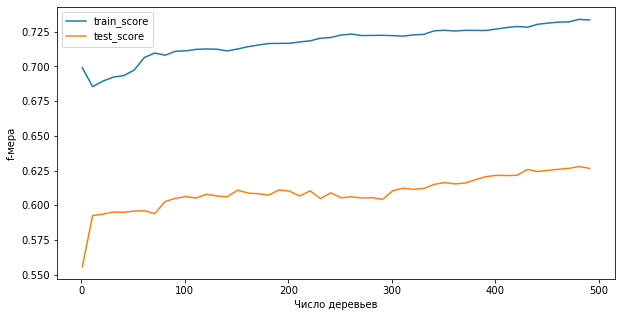

In [365]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(1, 500, 10), train_score, label = 'train_score')
plt.plot(np.arange(1, 500, 10), test_score, label = 'test_score')
plt.legend()
plt.xlabel('Число деревьев')
plt.ylabel('f-мера')
plt.show()

### Mix

In [131]:
from sklearn.ensemble import StackingClassifier

In [357]:
estimators = [('log', LogisticRegression(C=100, penalty='l2', solver='lbfgs', max_iter=400)), 
              
              ('r_forest', RandomForestClassifier(n_estimators=1000, min_samples_split=5, min_samples_leaf=8,
                                                  max_samples = 0.8, max_features = 'sqrt')),
              
              ('xgb', xgb.XGBClassifier(**best_params_xgb)),
              
              ('knn', KNeighborsClassifier(n_neighbors=12, weights='distance')),
              
              ('svm', SVC(C=1, kernel='rbf')) 
             ]

In [358]:
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), 
                                 cv=5, stack_method='auto')

In [359]:
stack_model.fit(X_train_scale, y_train)

StackingClassifier(cv=5,
                   estimators=[('log',
                                LogisticRegression(C=100, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=400,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False)),
                               ('r_forest',
                                RandomForestClassifier(bootstrap=True,
                           

# Предикт

In [360]:
X_test_scale = scaler.transform(X_test)

In [361]:
final_target = stack_model.predict(X_test_scale)

In [362]:
submission = pd.DataFrame(test_data['pair_id'])

In [363]:
submission['target'] = pd.Series(final_target, name='target')

In [364]:
submission.to_csv('submission_stack_5.csv', index=False)